In [ ]:
# Standard Libraries
import math
from sklearn.utils import resample
import pickle
import warnings
# Scientific Computing and Data Manipulation
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.spatial.distance import mahalanobis

# Machine Learning Models and Utilities
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    IsolationForest,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_classif
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    HalvingRandomSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score,
    learning_curve,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, label_binarize
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Imbalanced Learning
import imblearn
from imblearn.over_sampling import SMOTE

# Parallelization
from joblib import Parallel, delayed

# Google Colab Utilities
from google.colab import drive, files

# Warnings
warnings.filterwarnings('ignore')

# Google Drive Mount
drive.mount('/content/drive')

Mounted at /content/drive



Loaded Final Metrics:
Accuracy: 0.9872
Precision: 0.9298
Recall: 0.4300
F1_score: 0.5880
Roc_auc: 0.9368
Mcc: 0.6276

Confusion Matrix:
True Negatives: 517403, False Positives (Type I Error): 79
False Negatives (Type II Error): 1282, True Positives: 10102

Decision Tree Rules for Error Analysis:
|--- C14 <= 0.50
|   |--- Card_Transaction_Mean <= 58.84
|   |   |--- card6 <= 1.50
|   |   |   |--- TransactionDate <= 1483319388634349568.00
|   |   |   |   |--- card1 <= 9435.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- card1 >  9435.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- TransactionDate >  1483319388634349568.00
|   |   |   |   |--- TransactionDT <= 15412868.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TransactionDT >  15412868.00
|   |   |   |   |   |--- class: 0
|   |   |--- card6 >  1.50
|   |   |   |--- V307 <= 274.37
|   |   |   |   |--- Amt_To_DayOfWeek_Ratio <= 208.75
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Amt_To_DayOfWeek_Rat

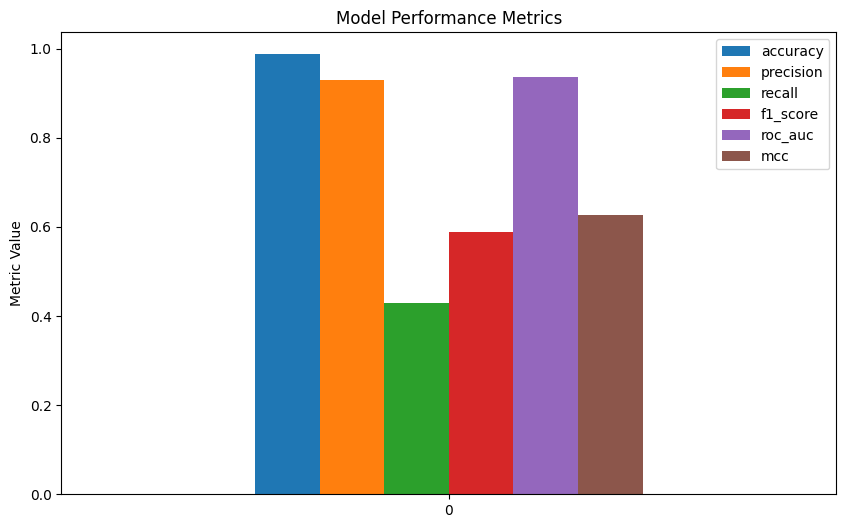

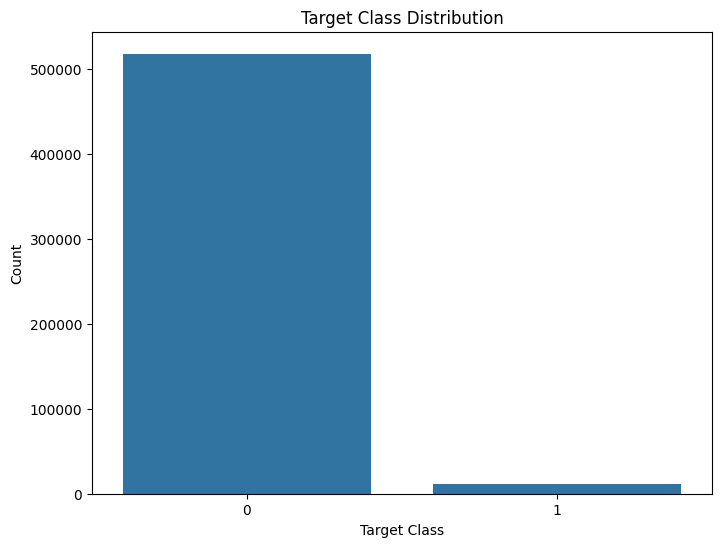

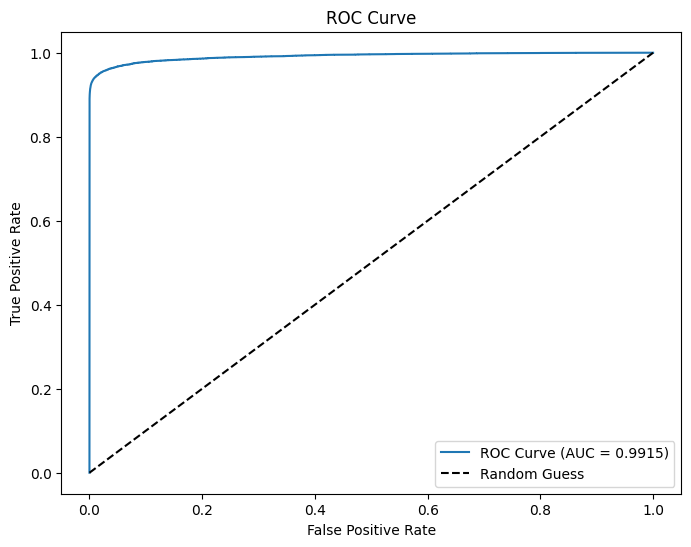

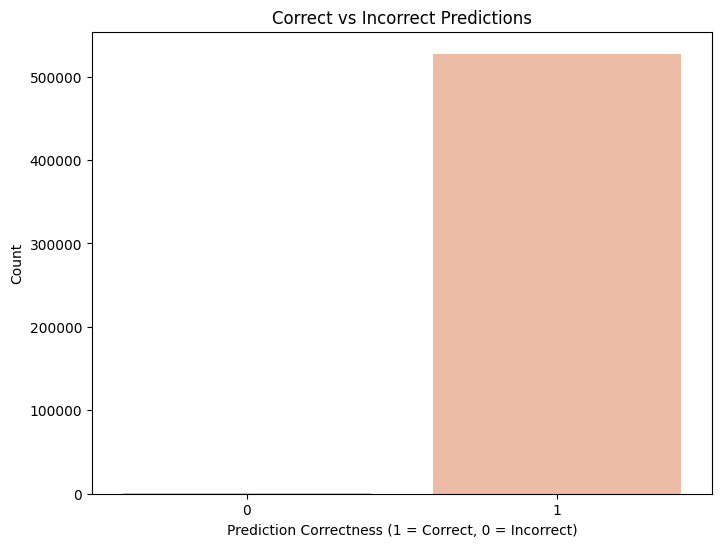

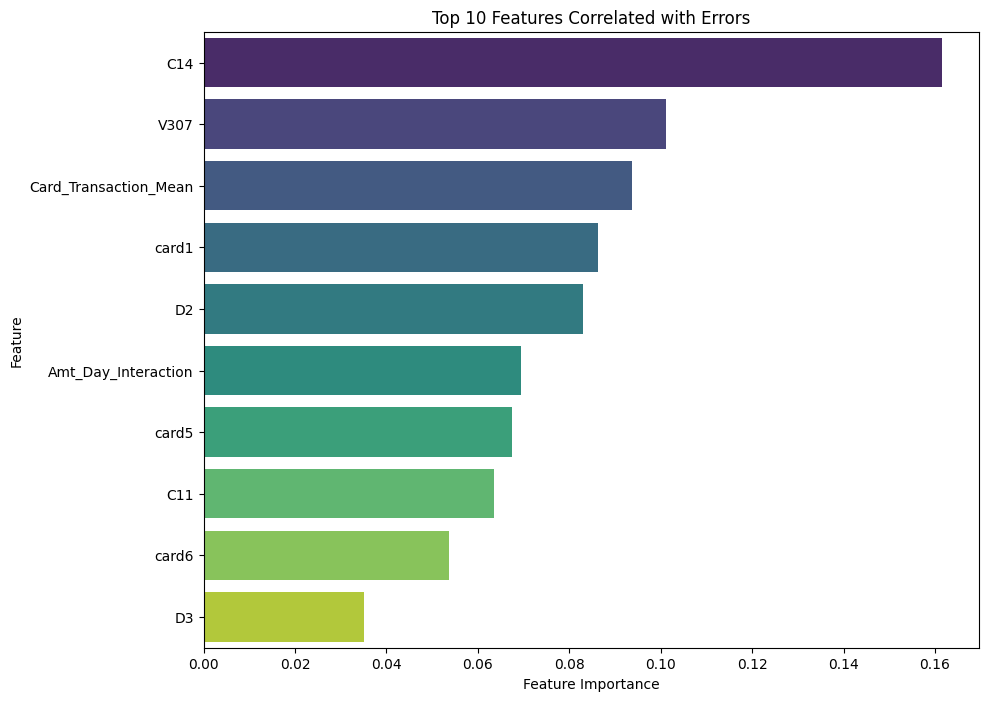

In [ ]:
# Paths to stored artifacts on Google Drive
features_path = '/content/drive/My Drive/IEEE_dataset/selected_features.pkl'
data_path = '/content/drive/My Drive/IEEE_dataset/preprocessed_data.pkl'
model_path = '/content/drive/My Drive/IEEE_dataset/voting_model_rf.pkl'
metrics_path = '/content/drive/My Drive/IEEE_dataset/final_metrics.pkl'

# Load Selected Features
with open(features_path, 'rb') as f:
    selected_features = pickle.load(f)

# Load Preprocessed Dataset
with open(data_path, 'rb') as f:
    data = pickle.load(f)
    X = data['X']
    y = data['y']

# Subset Data to Selected Features
X_selected = X[selected_features]

# Load Trained Voting Model
with open(model_path, 'rb') as f:
    voting_model = pickle.load(f)

# Optional: Load Final Metrics
with open(metrics_path, 'rb') as f:
    final_metrics = pickle.load(f)
    print("\nLoaded Final Metrics:")
    for metric, value in final_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

# Predict Using the Model
y_pred = voting_model.predict(X_selected)
y_prob = voting_model.predict_proba(X_selected)[:, 1] if hasattr(voting_model, 'predict_proba') else None

# Confusion Matrix and Error Analysis
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
print(f"\nConfusion Matrix:")
print(f"True Negatives: {tn}, False Positives (Type I Error): {fp}")
print(f"False Negatives (Type II Error): {fn}, True Positives: {tp}")

# Create Labels for Error Types
error_types = np.zeros_like(y)
error_types[(y == 1) & (y_pred == 0)] = 1  # Type II Error
error_types[(y == 0) & (y_pred == 1)] = 2  # Type I Error

# Train CART Decision Tree on Errors
cart_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
cart_tree.fit(X_selected, error_types)

# Interpret Decision Tree
tree_rules = export_text(cart_tree, feature_names=list(X_selected.columns))
print("\nDecision Tree Rules for Error Analysis:")
print(tree_rules)

# Analyze Feature Importance for Errors
feature_importance = cart_tree.feature_importances_
important_features = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("\nTop Features Correlated with Errors:")
print(important_features.head())

# Save Results for Future Analysis
important_features_path = '/content/drive/My Drive/IEEE_dataset/error_analysis_features.pkl'
important_features.to_pickle(important_features_path)
print(f"\nSaved important features to {important_features_path}")

# Generalization Analysis: Visualization of Metrics
metrics = pd.DataFrame(final_metrics, index=[0])
metrics.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.show()

# Distribution of Target Classes
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.ylabel("Count")
plt.xlabel("Target Class")
plt.show()

# ROC Curve
if y_prob is not None:
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Correct vs Incorrect Predictions
correct_predictions = (y == y_pred).astype(int)
plt.figure(figsize=(8, 6))
sns.countplot(x=correct_predictions, palette="coolwarm")
plt.title("Correct vs Incorrect Predictions")
plt.ylabel("Count")
plt.xlabel("Prediction Correctness (1 = Correct, 0 = Incorrect)")
plt.show()

# Feature Importance Analysis: Top Features
plt.figure(figsize=(10, 8))
sns.barplot(data=important_features.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Features Correlated with Errors")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()



Fraudulent Transactions Analysis:
Total Fraudulent Transactions: 11384
Fraudulent Transactions Caught (True Positives): 10102
Fraudulent Transactions Missed (False Negatives): 1282


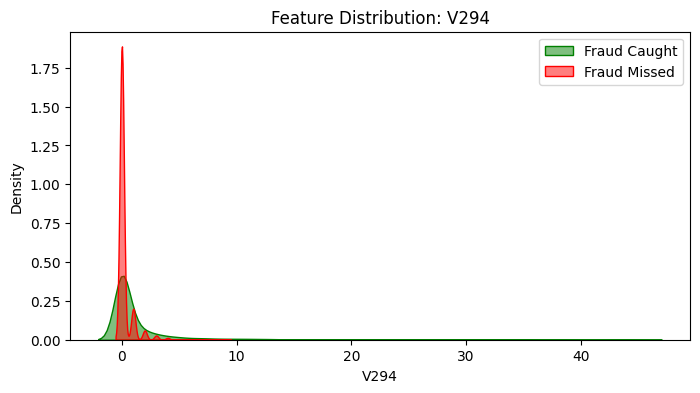

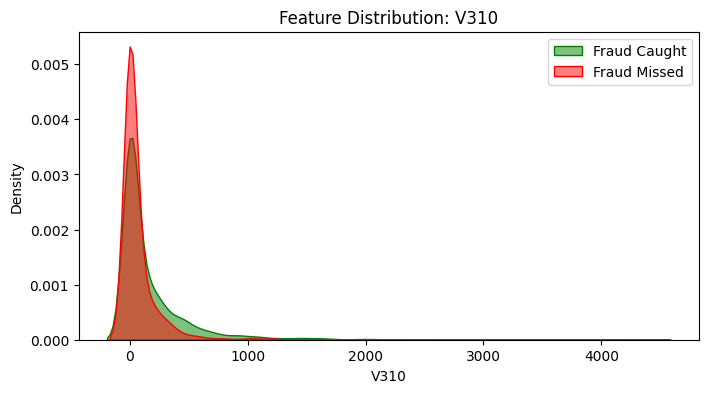

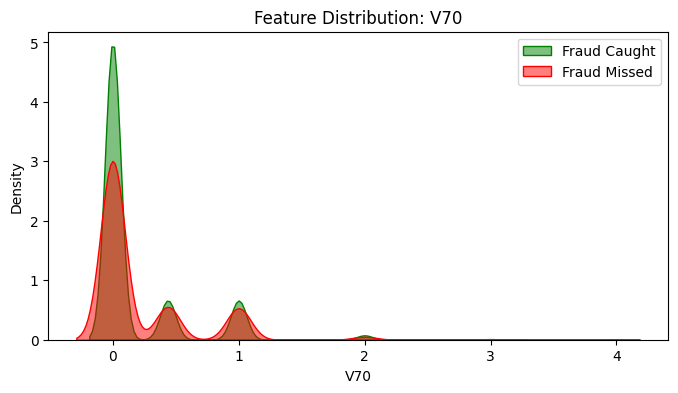

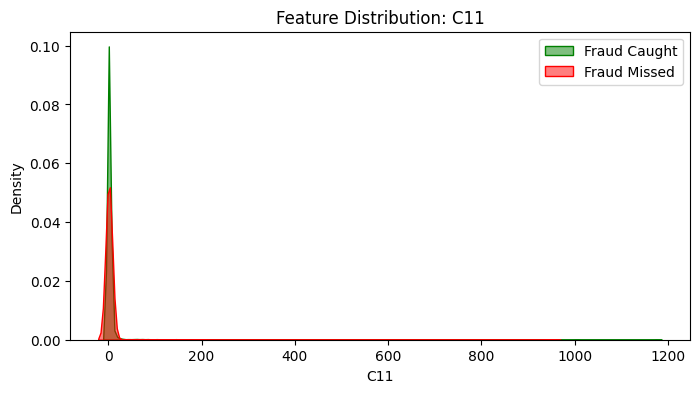

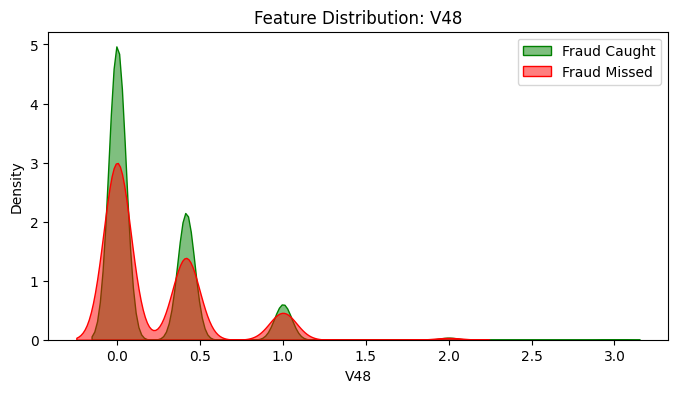

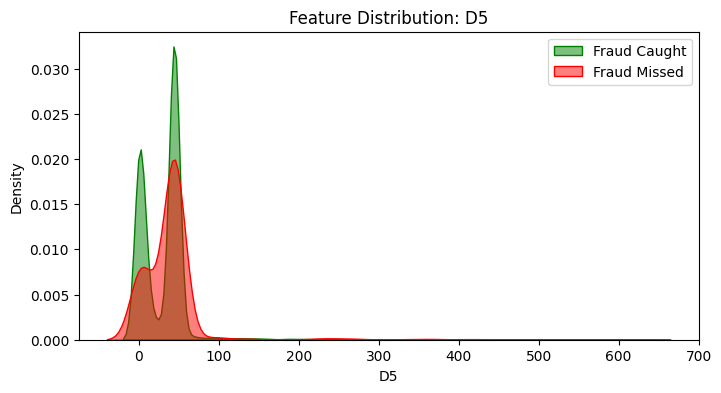

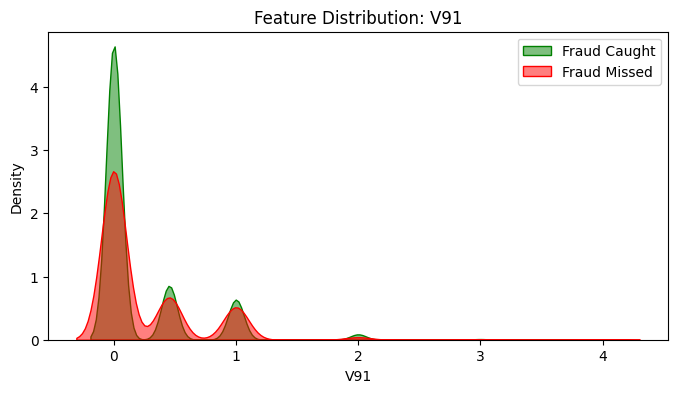

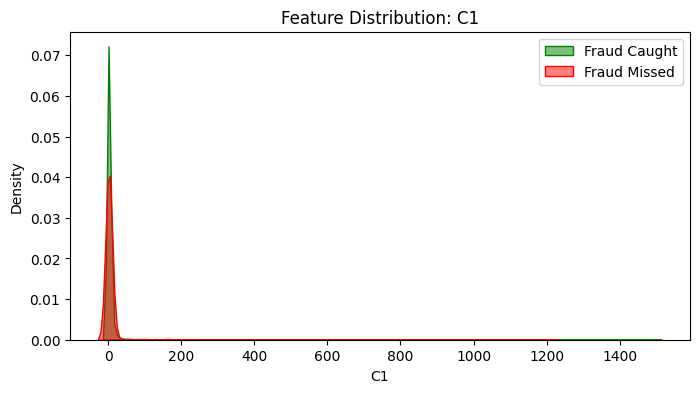

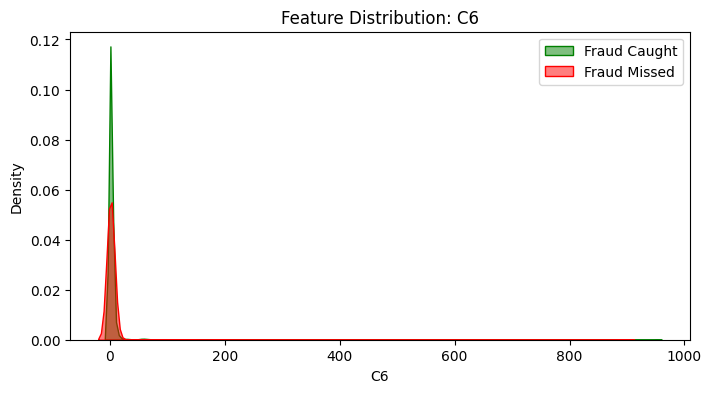

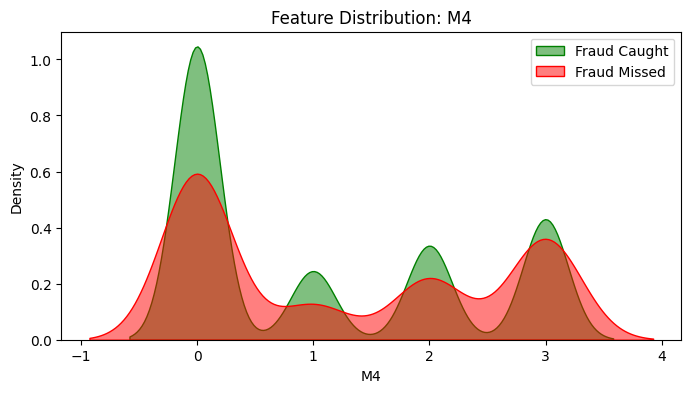

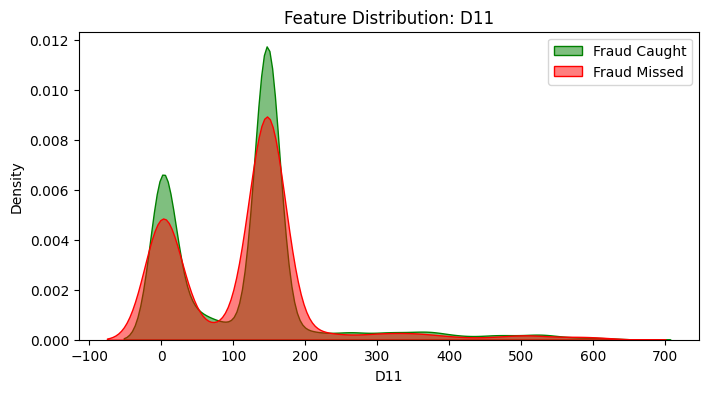

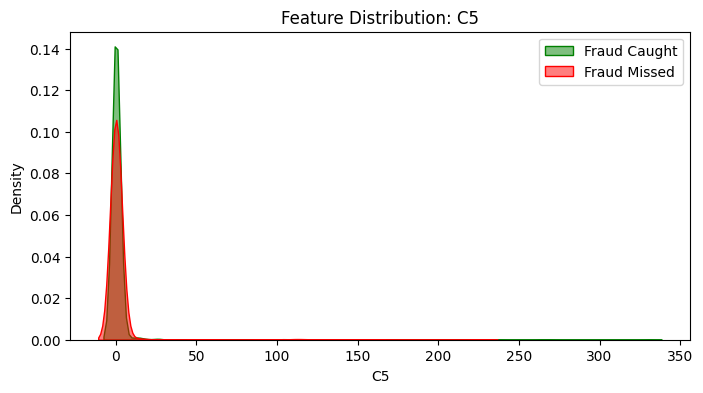

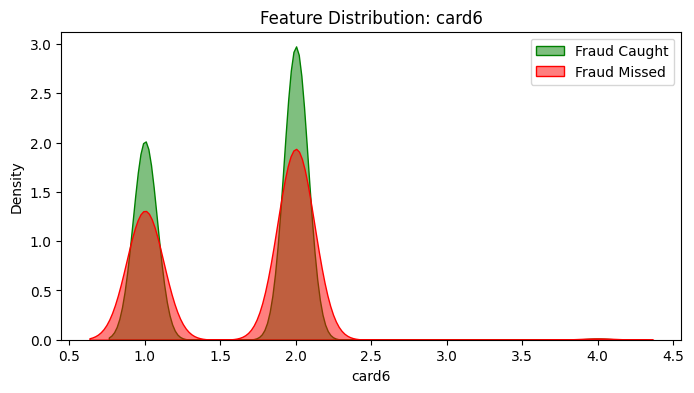

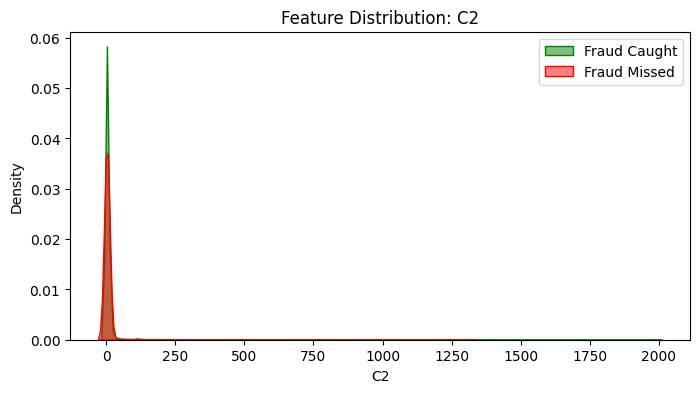

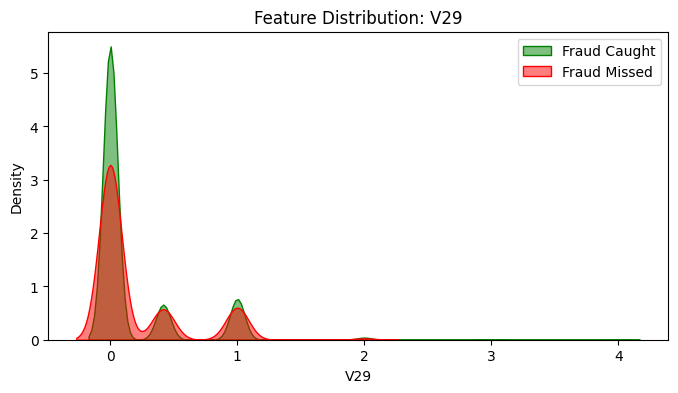

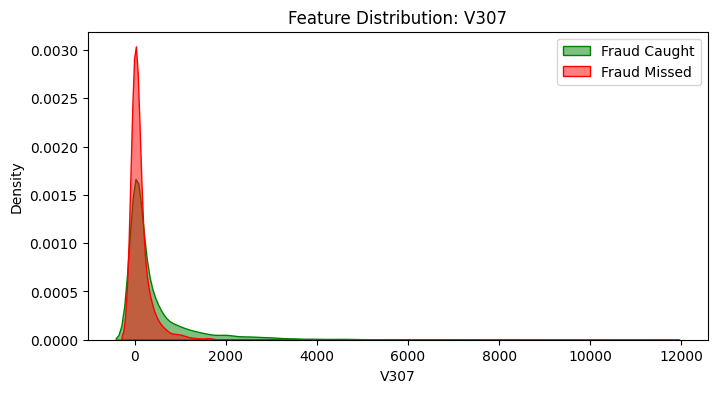

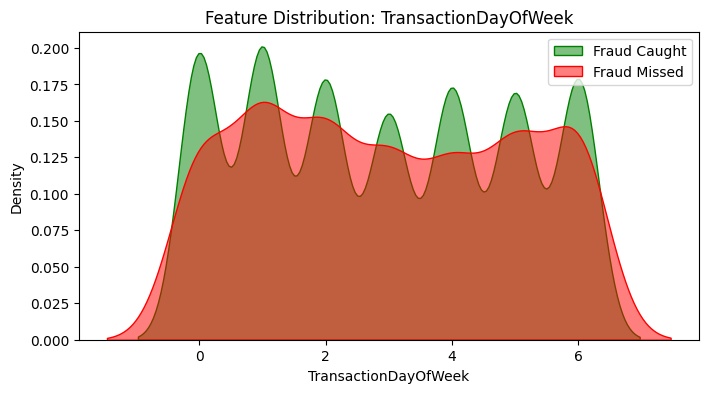

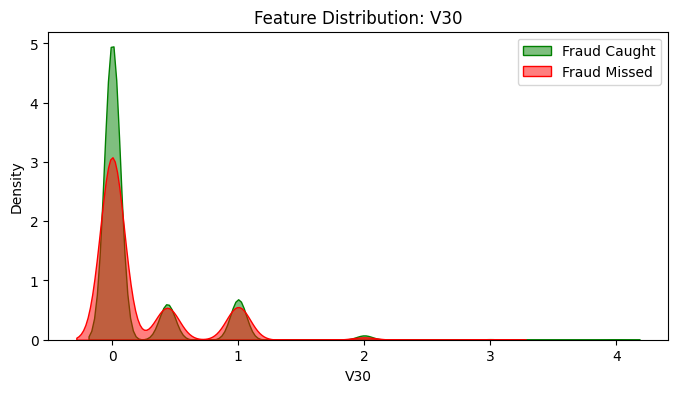

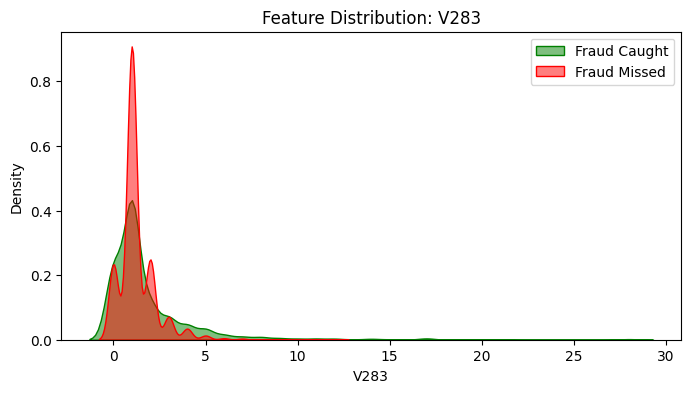

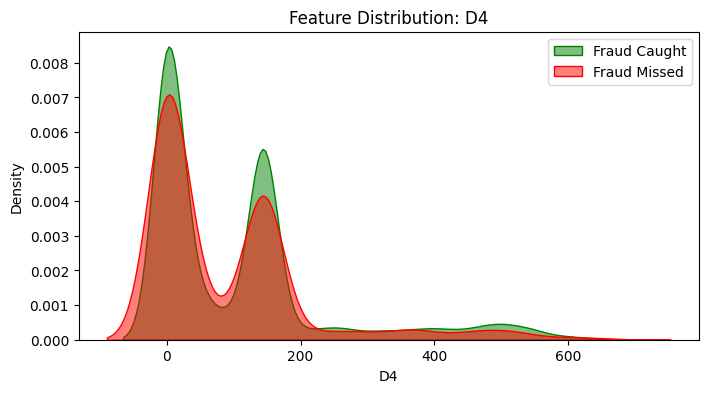

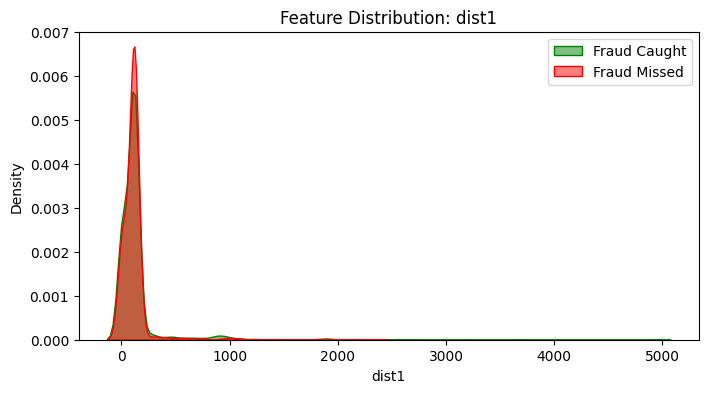

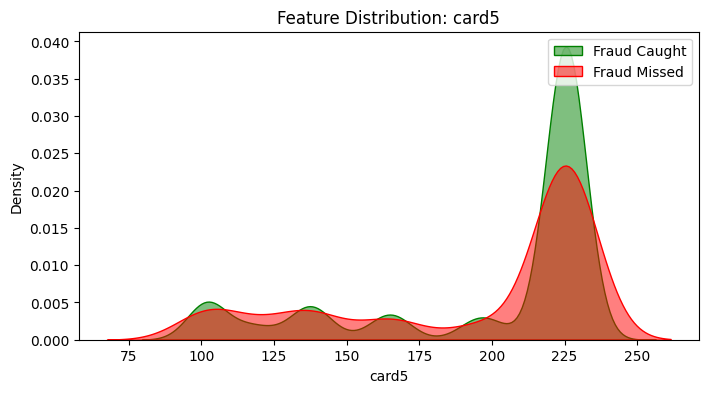

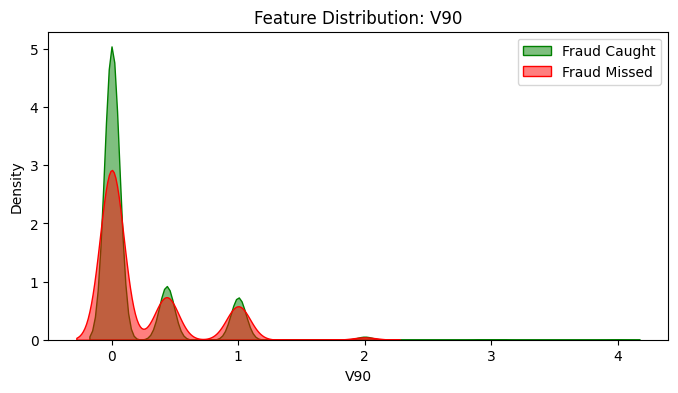

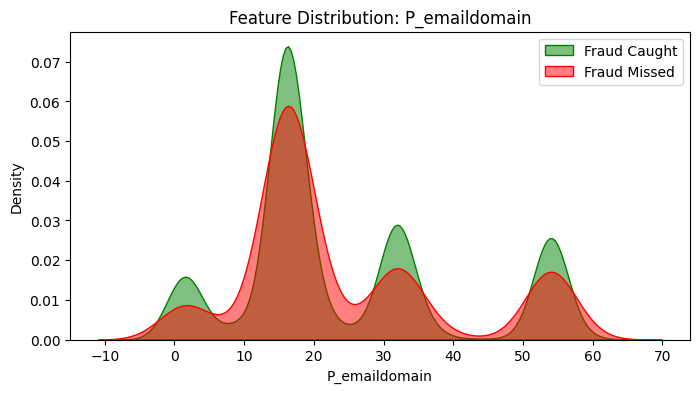

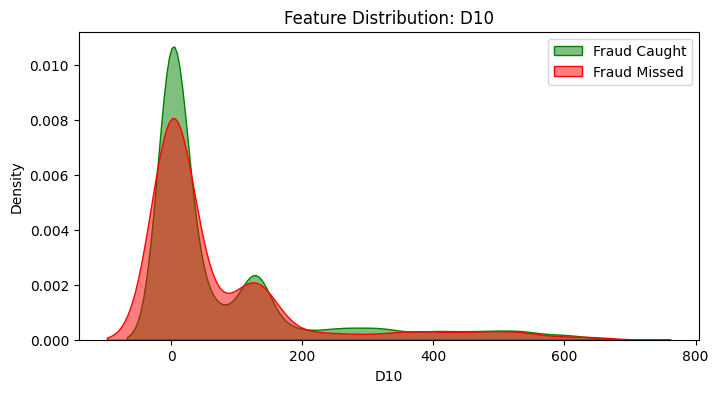

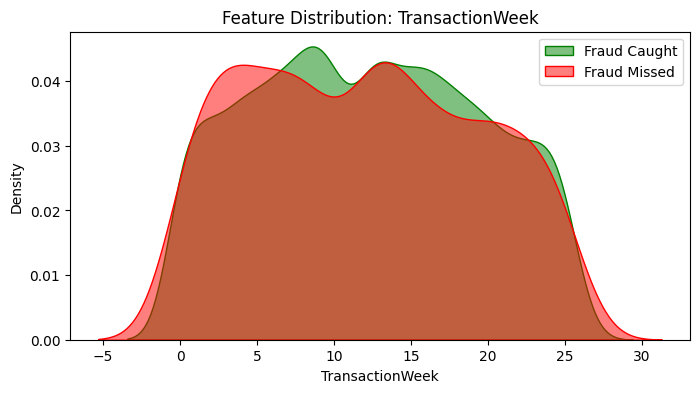

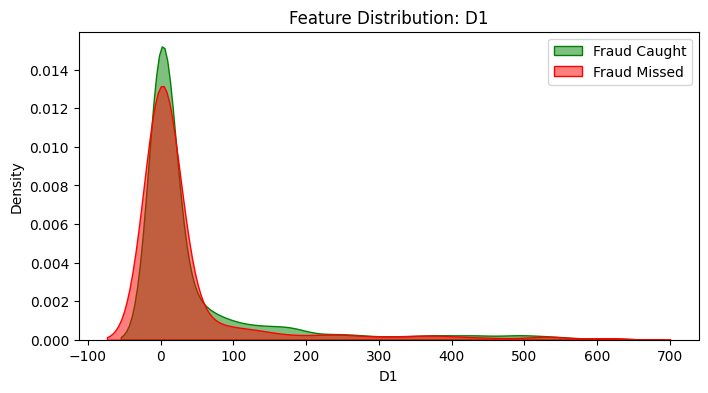

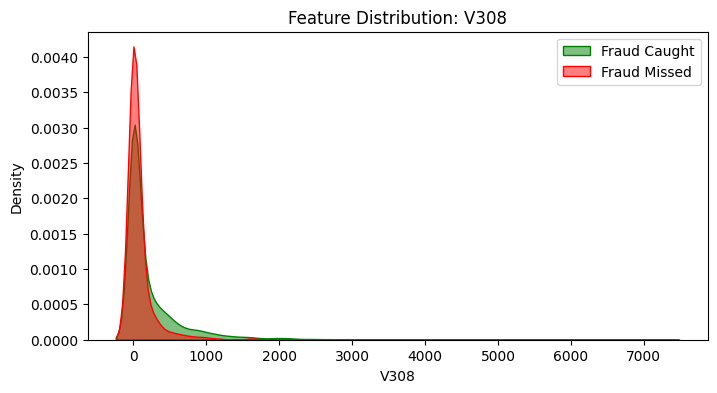

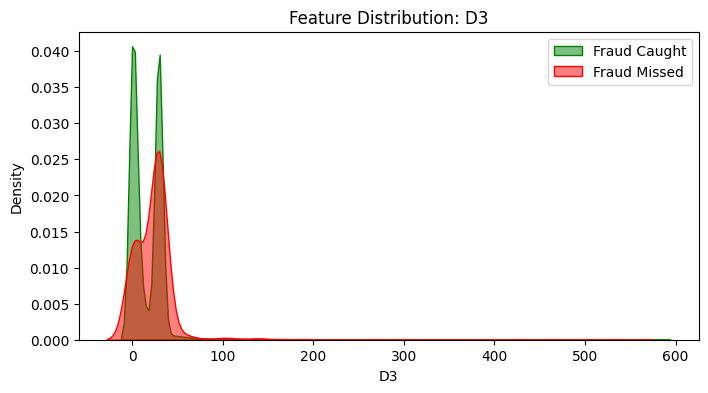

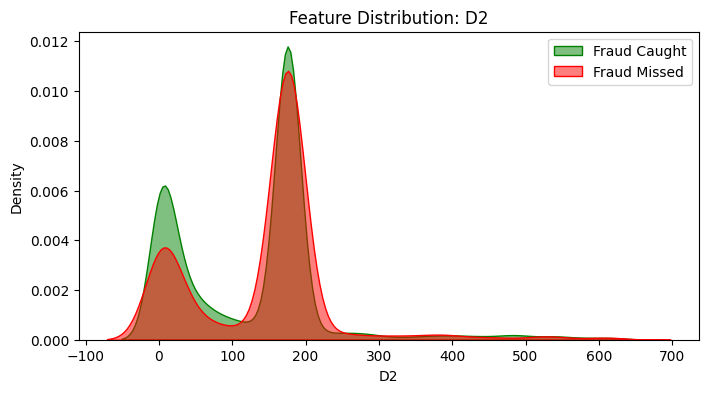

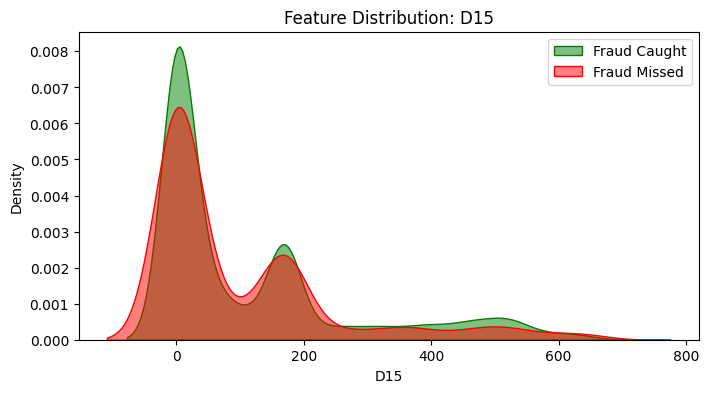

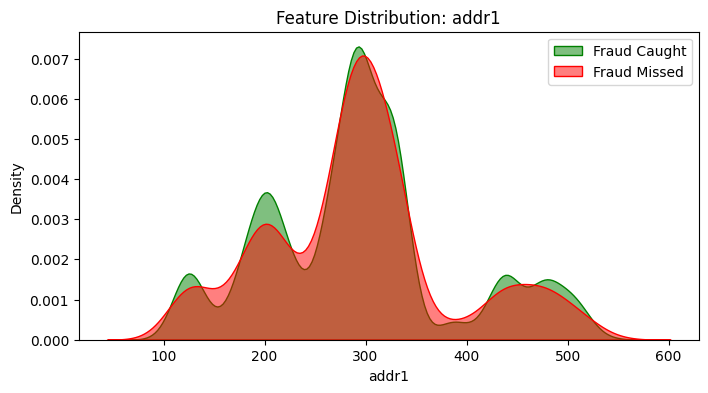

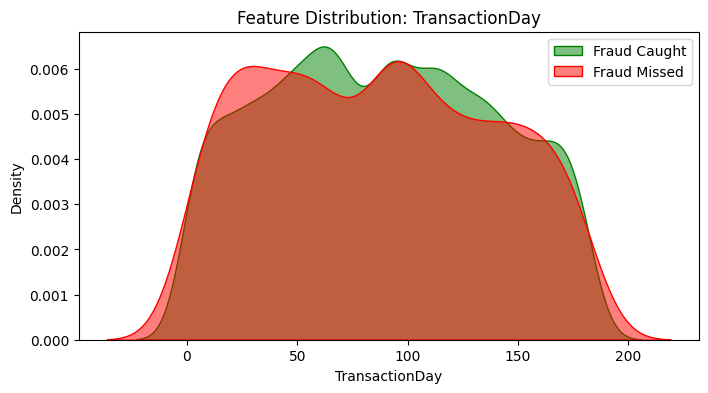

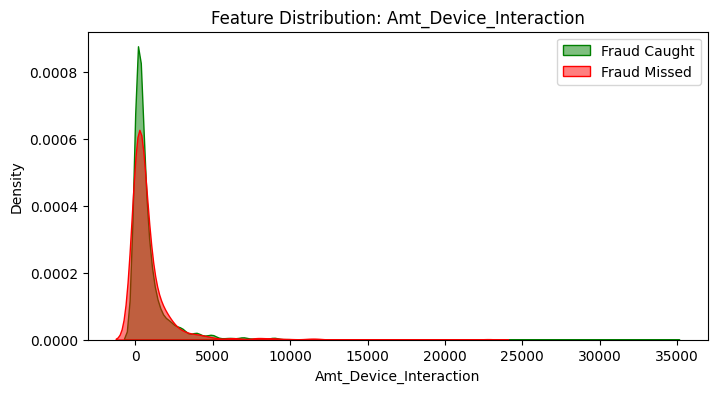

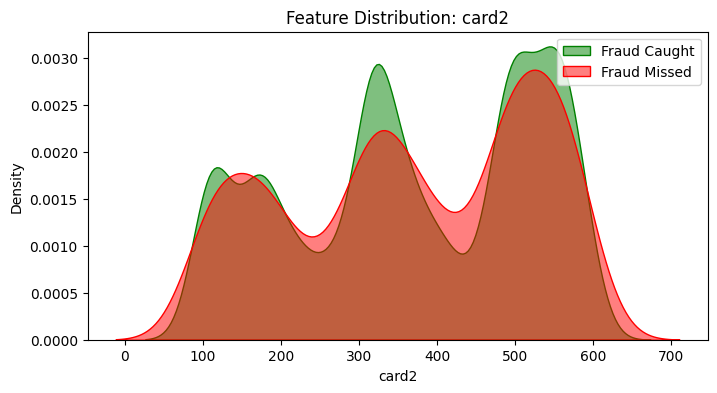

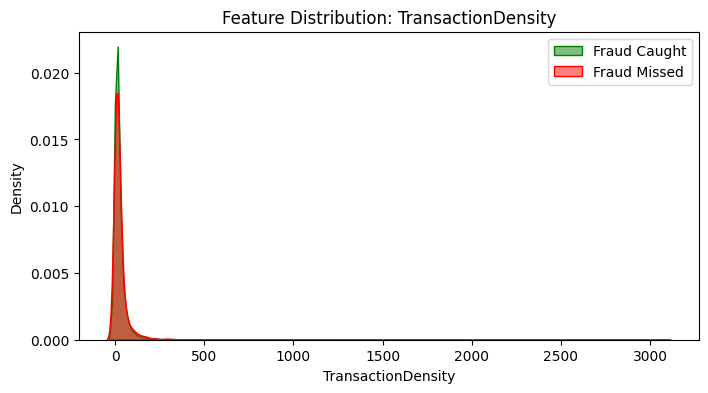

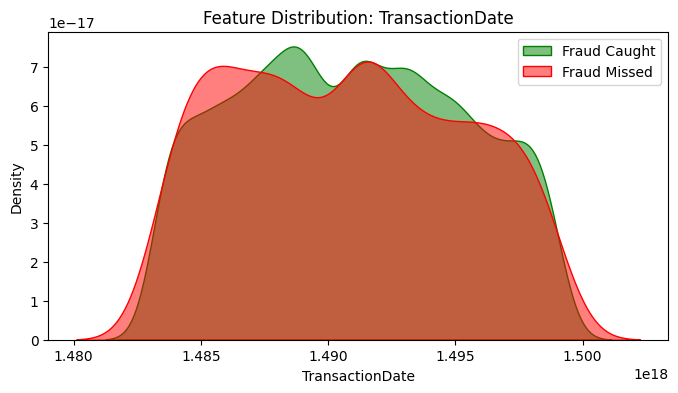

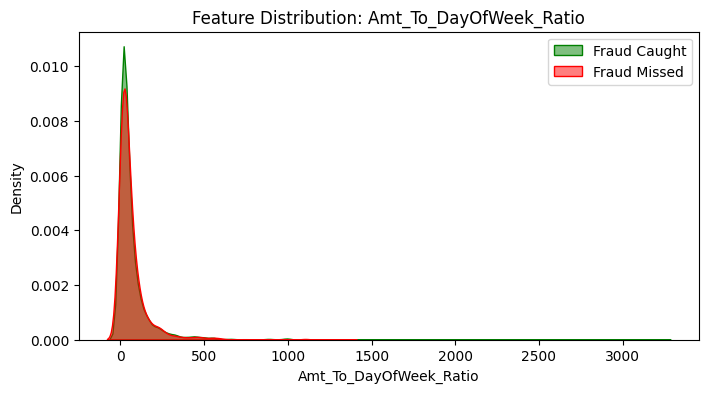

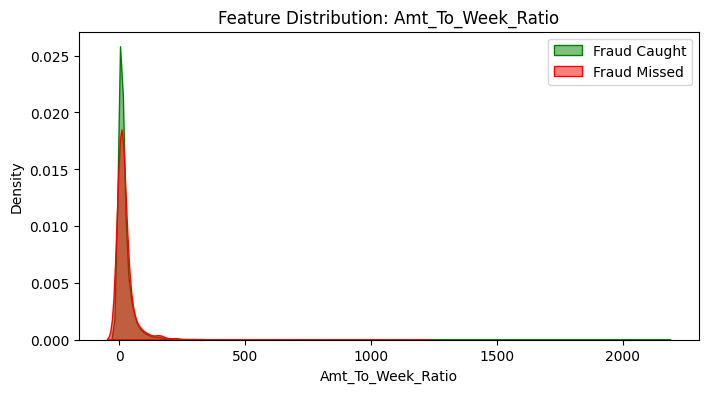

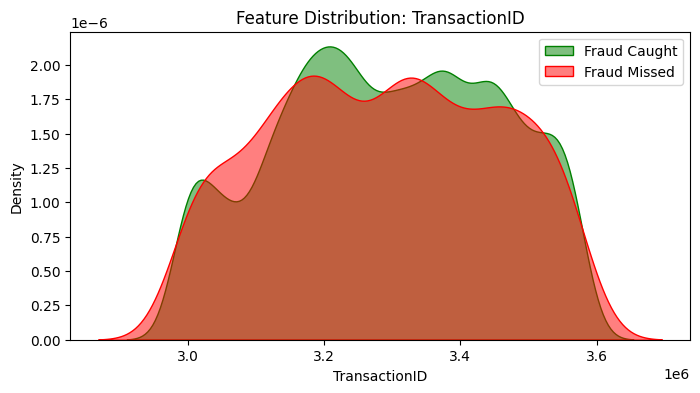

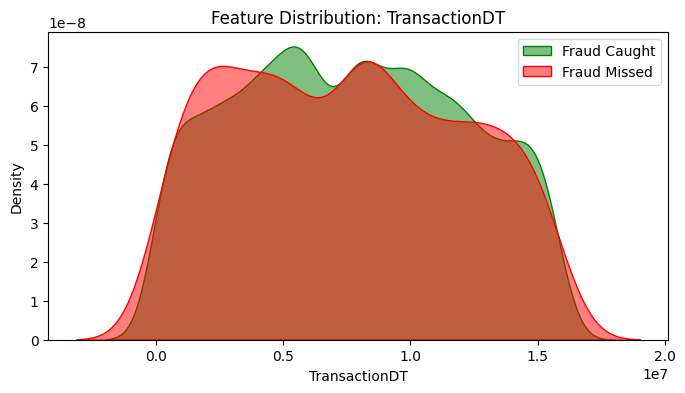

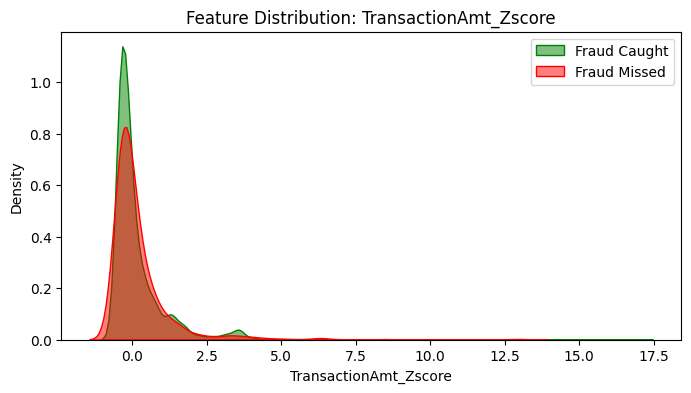

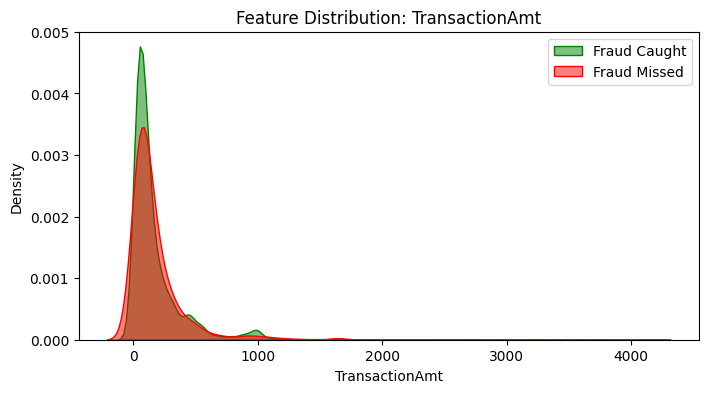

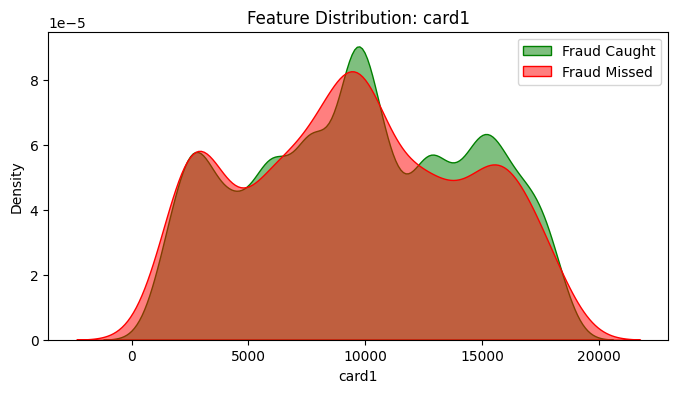

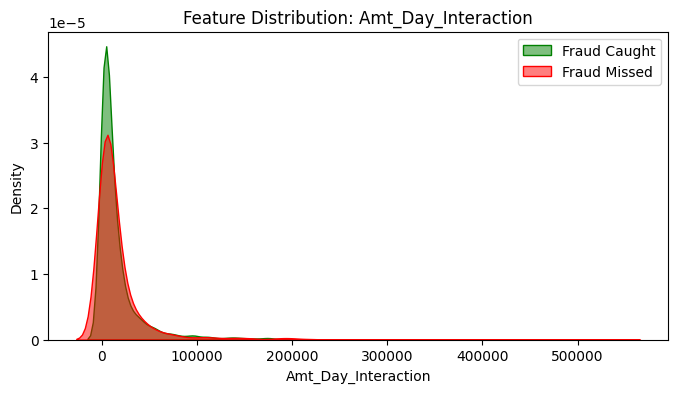

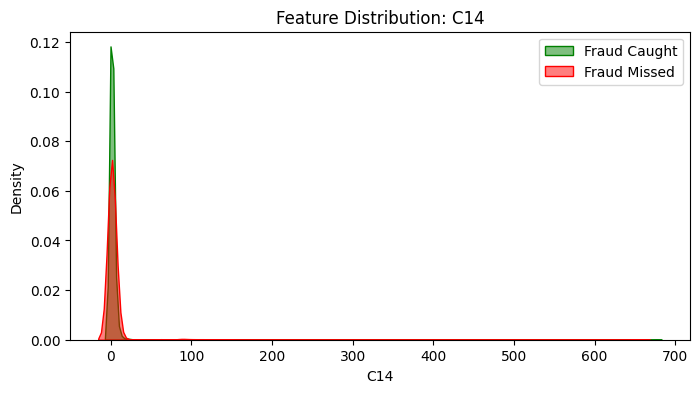

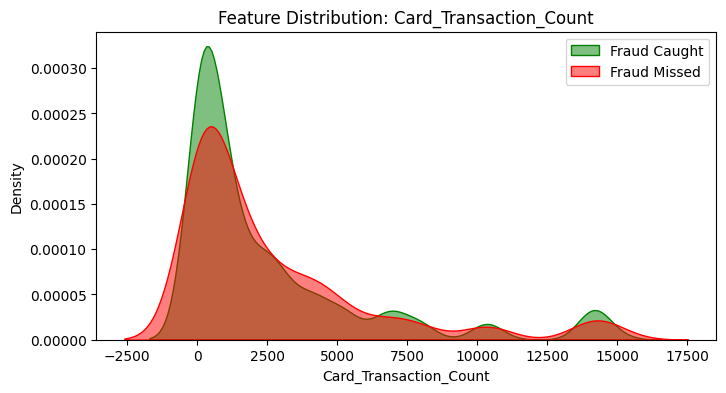

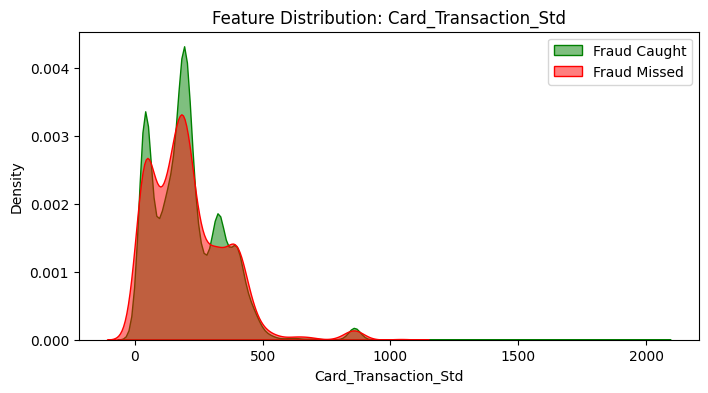

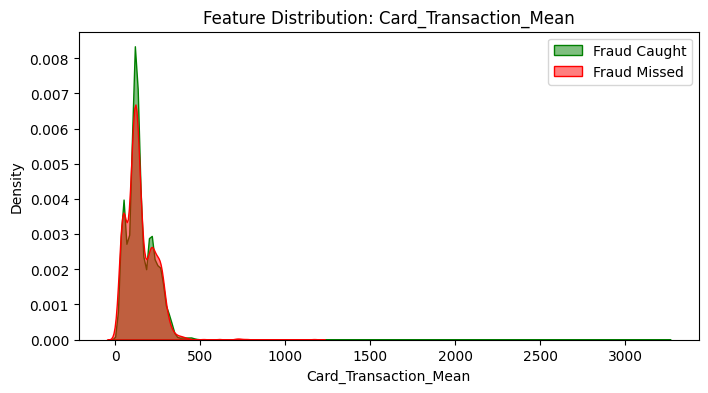

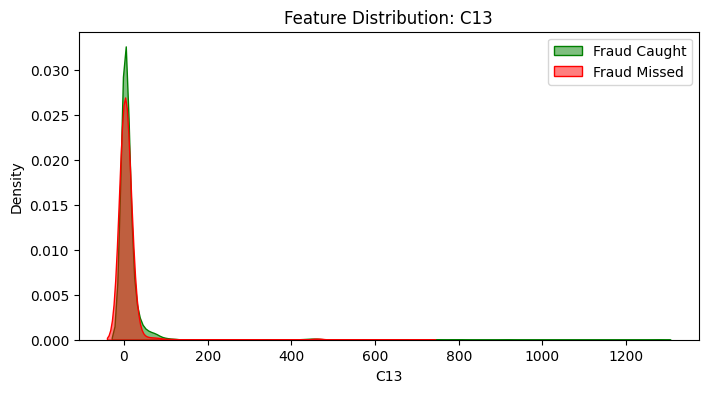


Summary Statistics for Caught vs Missed Fraud:
                  Caught_Mean    Caught_Std   Missed_Mean    Missed_Std  \
TransactionDate  1.490907e+18  4.371517e+15  1.490738e+18  4.486521e+15   
TransactionDT    7.677858e+06  4.371517e+06  7.508743e+06  4.486521e+06   
TransactionID    3.294502e+06  1.607961e+05  3.288012e+06  1.650694e+05   
V307             4.515982e+02  8.841798e+02  1.357571e+02  4.065052e+02   
card1            9.760819e+03  4.703142e+03  9.505204e+03  4.724044e+03   
V308             2.426776e+02  5.134111e+02  8.605825e+01  3.239062e+02   
V310             1.900614e+02  4.095922e+02  7.423538e+01  2.361094e+02   
dist1            1.446112e+02  2.811982e+02  1.179478e+02  1.768801e+02   
D4               1.049906e+02  1.381601e+02  8.919072e+01  1.250440e+02   
D1               5.290631e+01  1.156230e+02  3.755789e+01  1.030211e+02   

                 Difference_Mean  
TransactionDate     1.691150e+14  
TransactionDT       1.691150e+05  
TransactionID       6

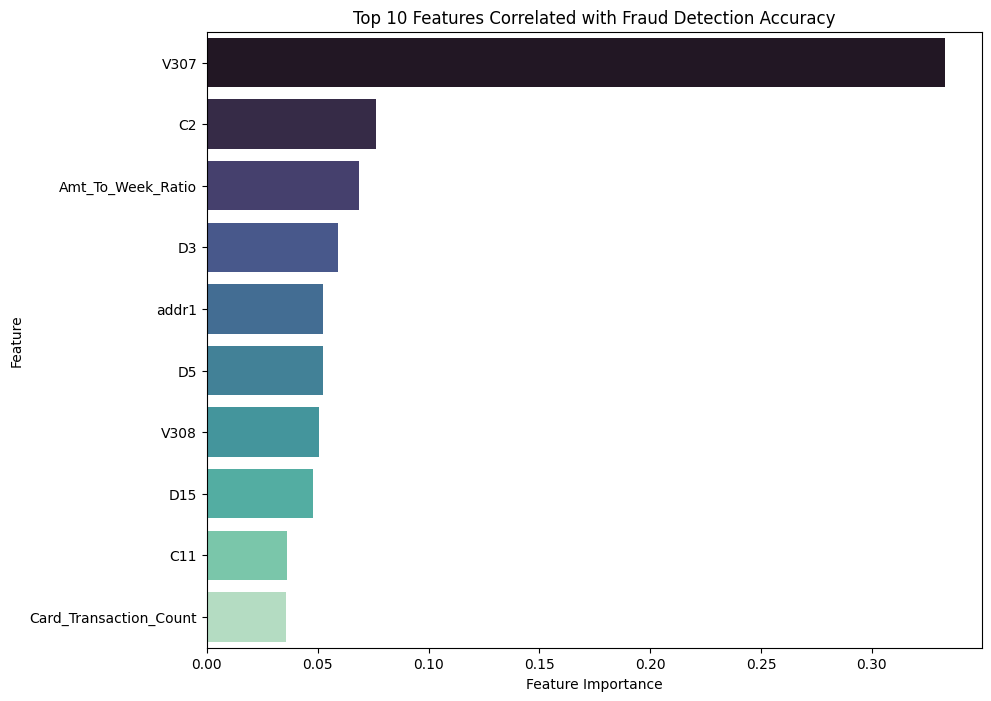

In [ ]:
# Subset Fraudulent Transactions
fraud_data = X_selected[y == 1]  # Transactions labeled as fraud
fraud_caught = X_selected[(y == 1) & (y_pred == 1)]  # Fraud detected
fraud_missed = X_selected[(y == 1) & (y_pred == 0)]  # Fraud missed

print(f"\nFraudulent Transactions Analysis:")
print(f"Total Fraudulent Transactions: {len(fraud_data)}")
print(f"Fraudulent Transactions Caught (True Positives): {len(fraud_caught)}")
print(f"Fraudulent Transactions Missed (False Negatives): {len(fraud_missed)}")

# Compare feature distributions for caught vs missed fraud
for feature in X_selected.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(fraud_caught[feature], label='Fraud Caught', color='green', fill=True, alpha=0.5)
    sns.kdeplot(fraud_missed[feature], label='Fraud Missed', color='red', fill=True, alpha=0.5)
    plt.title(f"Feature Distribution: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Summary statistics for caught vs missed fraud
summary_stats = pd.DataFrame({
    'Caught_Mean': fraud_caught.mean(),
    'Caught_Std': fraud_caught.std(),
    'Missed_Mean': fraud_missed.mean(),
    'Missed_Std': fraud_missed.std()
})
summary_stats['Difference_Mean'] = summary_stats['Caught_Mean'] - summary_stats['Missed_Mean']
print("\nSummary Statistics for Caught vs Missed Fraud:")
print(summary_stats.sort_values(by='Difference_Mean', ascending=False).head(10))

# Train a Decision Tree on Fraud Data to Differentiate Caught vs Missed
fraud_labels = np.zeros_like(y[y == 1])  # Initialize labels
fraud_labels[y_pred[y == 1] == 1] = 1   # Label caught fraud as 1

cart_tree_fraud = DecisionTreeClassifier(random_state=42, max_depth=5)
cart_tree_fraud.fit(fraud_data, fraud_labels)

# Feature importance for fraud-specific analysis
fraud_feature_importance = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': cart_tree_fraud.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features Correlated with Fraud Detection Accuracy:")
print(fraud_feature_importance.head(10))

# Plot top 10 features for fraud detection
plt.figure(figsize=(10, 8))
sns.barplot(data=fraud_feature_importance.head(10), x="Importance", y="Feature", palette="mako")
plt.title("Top 10 Features Correlated with Fraud Detection Accuracy")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

# Analyzing transaction amounts for caught vs missed fraud
if 'TransactionAmount' in X_selected.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[fraud_caught['TransactionAmount'], fraud_missed['TransactionAmount']],
                notch=True, palette="coolwarm")
    plt.title("Transaction Amount: Fraud Caught vs Missed")
    plt.xticks([0, 1], ['Caught Fraud', 'Missed Fraud'])
    plt.ylabel("Transaction Amount")
    plt.show()


# **Multi-Peak in Feature Distribution Explanation:**

-The multiple peaks suggest the data may come from different groups or processes, like fraud vs. legitimate transactions. It could also result from SMOTE balancing or how features are encoded. These patterns often hold valuable insights, especially for models like Random Forest or XGBoost, which handle complexity well.

# **Vesta Co. Encoded Masked Feature Meanings:**


1.   C1 - C14: Counts (Example: How many payment locations, phone numbers, names, etc...)
2.   M1 - M9: Matches (Example: Payment Locations, names, phone numbers, etc..)
1.   D1 - D15: Duration of Time (Example: How long between transactions, duration since transactional card was started, etc..)
2.   V1 - V339: Vesta Co Encoded Features (Example: Cummulative Transaction Amount, etc..)
1.   id_01 - id_38: Identification Information (Names removed for privacy) (Example: os version, browser version, ISP, etc..)







